<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Vector_Quantized_Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vector-Quantized Variational Autoencoders**

In this example, we develop a Vector Quantized Variational Autoencoder (VQ-VAE).
VQ-VAE was proposed in
[Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)
by van der Oord et al. In standard VAEs, the latent space is continuous and is sampled
from a Gaussian distribution. It is generally harder to learn such a continuous
distribution via gradient descent. VQ-VAEs, on the other hand,
operate on a discrete latent space, making the optimization problem simpler. It does so
by maintaining a discrete *codebook*. The codebook is developed by
discretizing the distance between continuous embeddings and the encoded
outputs. These discrete code words are then fed to the decoder, which is trained
to generate reconstructed samples.

For an overview of VQ-VAEs, please refer to the original paper and
[this video explanation](https://www.youtube.com/watch?v=VZFVUrYcig0).
If you need a refresher on VAEs, you can refer to
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/).
VQ-VAEs are one of the main recipes behind [DALL-E](https://openai.com/blog/dall-e/)
and the idea of a codebook is used in [VQ-GANs](https://arxiv.org/abs/2012.09841).
This example uses implementation details from the
[official VQ-VAE tutorial](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb)
from DeepMind.

## Requirements

To run this example, you will need TensorFlow 2.5 or higher, as well as
TensorFlow Probability, which can be installed using the command below.

In [1]:
!pip install -q tensorflow-probability

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

## `VectorQuantizer` layer

First, we implement a custom layer for the vector quantizer, which is the layer in between
the encoder and decoder. Consider an output from the encoder, with shape `(batch_size, height, width,
num_filters)`. The vector quantizer will first flatten this output, only keeping the
`num_filters` dimension intact. So, the shape would become `(batch_size * height * width,
num_filters)`. The rationale behind this is to treat the total number of filters as the size for
the latent embeddings.

An embedding table is then initialized to learn a codebook. We measure the L2-normalized
distance between the flattened encoder outputs and code words of this codebook. We take the
code that yields the minimum distance, and we apply one-hot encoding to achieve quantization.
This way, the code yielding the minimum distance to the corresponding encoder output is
mapped as one and the remaining codes are mapped as zeros.

Since the quantization process is not differentiable, we apply a
[straight-through estimator](https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html)
in between the decoder and the encoder, so that the decoder gradients are directly propagated
to the encoder. As the encoder and decoder share the same channel space, the decoder gradients are
still meaningful to the encoder.

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

**A note on straight-through estimation**:

This line of code does the straight-through estimation part: `quantized = x +
tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be
included in the computation graph and the gradients obtained for `quantized`
will be copied for `inputs`. Thanks to [this video](https://youtu.be/VZFVUrYcig0?t=1393)
for helping me understand this technique.



## Encoder and decoder

Now for the encoder and the decoder for the VQ-VAE. We will keep them small so
that their capacity is a good fit for the MNIST dataset. The implementation of the encoder and
decoder come from
[this example](https://keras.io/examples/generative/vae).

Note that activations _other than ReLU_ may not work for the encoder and decoder layers in the
quantization architecture: Leaky ReLU activated layers, for example, have proven difficult to
train, resulting in intermittent loss spikes that the model has trouble recovering from.

In [4]:
def get_encoder(latent_dim = 16):
    encoder_inputs = keras.Input(shape = (28, 28, 1))
    x = layers.Conv2D(32, 3, strides = 2, padding = "same", activation = "relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides = 2, padding = "same", activation = "relu")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding = "same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name = "encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

## Standalone VQ-VAE model

In [5]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQu  (None, 7, 7, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48913 (191.07 KB)
Trainable params: 48913 (191.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the output channels of the encoder should match the `latent_dim` for the vector
quantizer.



## Wrapping up the training loop inside `VQVAETrainer`

In [6]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

## Load and preprocess the MNIST dataset

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11490434/11490434 [==============================] - 2s 0us/step


## Train the VQ-VAE model

In [8]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 12s 13ms/step - loss: 2.5847 - reconstruction_loss: 0.3556 - vqvae_loss: 1.8714
Epoch 2/30
469/469 [==============================] - 5s 11ms/step - loss: 1.9962 - reconstruction_loss: 0.1457 - vqvae_loss: 1.8444
Epoch 3/30
469/469 [==============================] - 5s 11ms/step - loss: 1.0418 - reconstruction_loss: 0.1226 - vqvae_loss: 0.9132
Epoch 4/30
469/469 [==============================] - 6s 13ms/step - loss: 0.5970 - reconstruction_loss: 0.1017 - vqvae_loss: 0.4912
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 0.4387 - reconstruction_loss: 0.0890 - vqvae_loss: 0.3472
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.3729 - reconstruction_loss: 0.0790 - vqvae_loss: 0.2913
Epoch 7/30
469/469 [==============================] - 5s 11ms/step - loss: 0.3098 - reconstruction_loss: 0.0708 - vqvae_loss: 0.2372
Epoch 8/30
469/469 [==============================] - 4s 10ms/step - l

## Reconstruction results on the test set

1/1 [==============================] - 0s 280ms/step


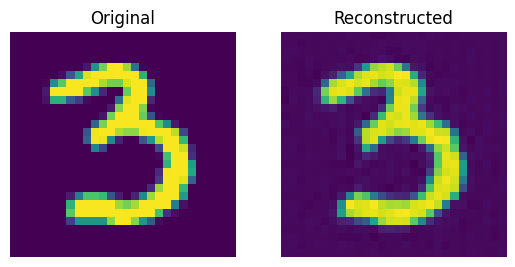

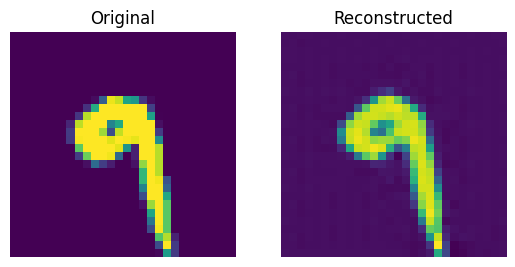

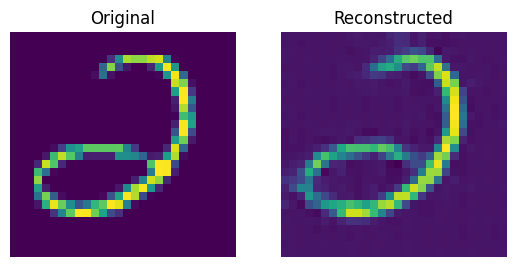

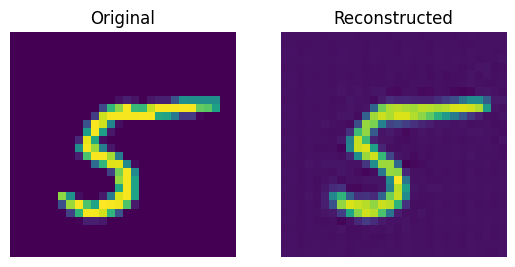

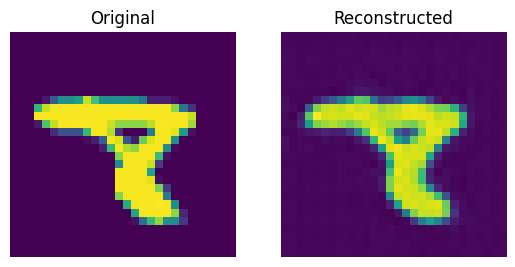

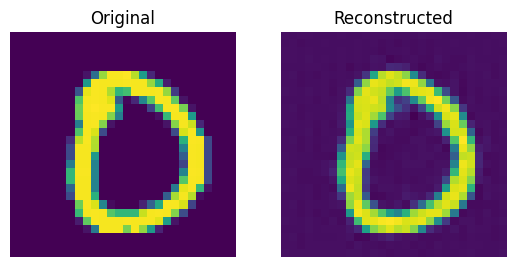

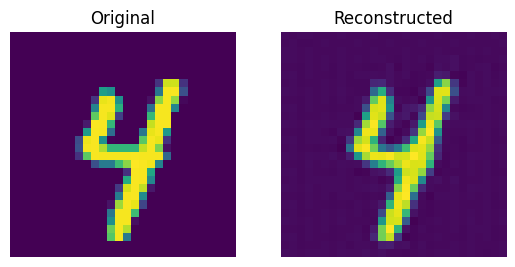

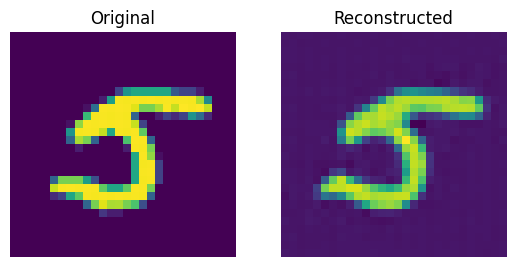

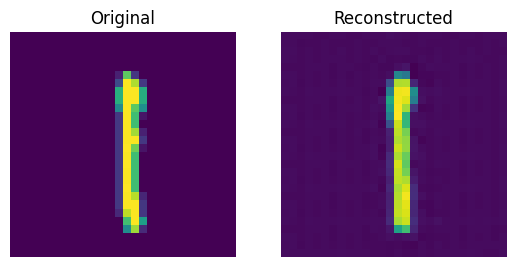

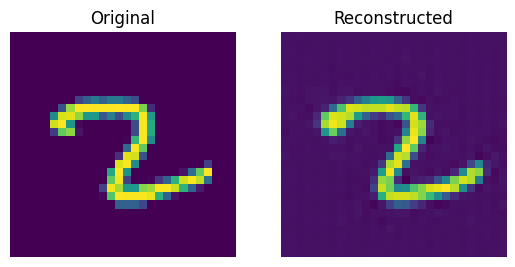

In [9]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

These results look decent. You are encouraged to play with different hyperparameters
(especially the number of embeddings and the dimensions of the embeddings) and observe how
they affect the results.



## Visualizing the discrete codes

1/1 [==============================] - 0s 50ms/step


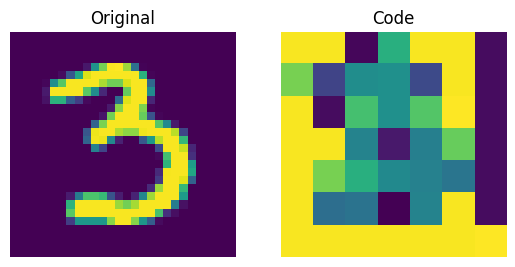

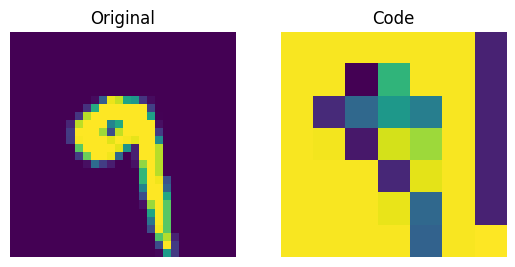

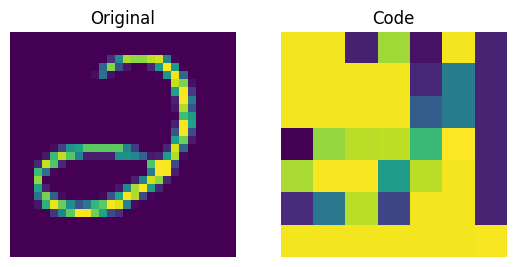

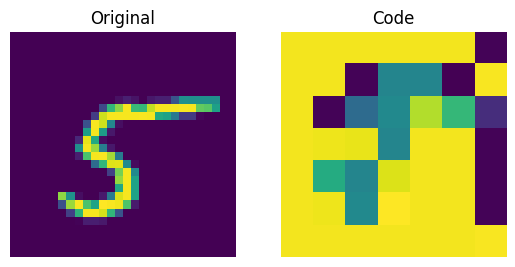

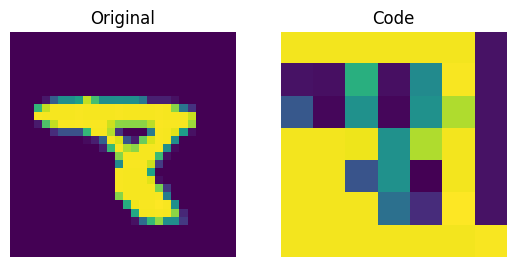

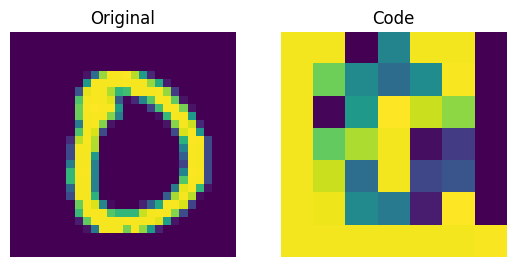

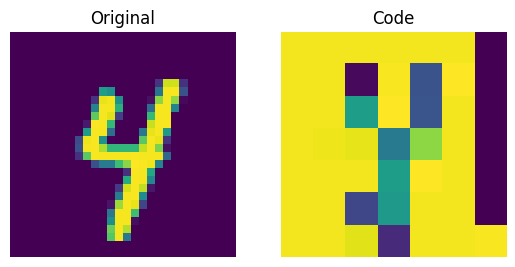

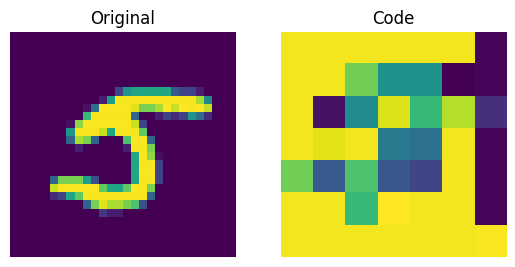

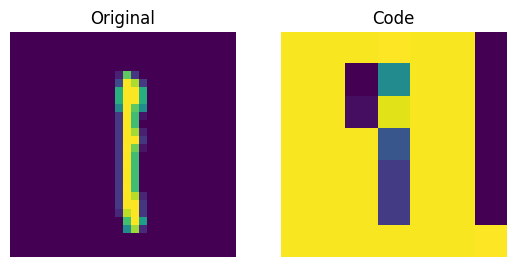

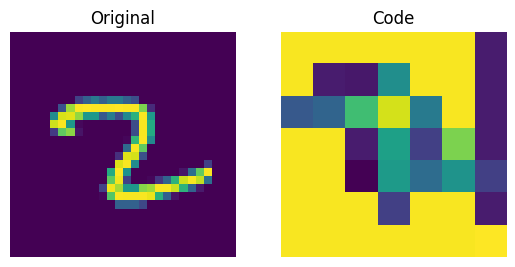

In [10]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

The figure above shows that the discrete codes have been able to capture some
regularities from the dataset. Now, how do we sample from this codebook to create
novel images? Since these codes are discrete and we imposed a categorical distribution
on them, we cannot use them yet to generate anything meaningful until we can generate likely
sequences of codes that we can give to the decoder.

The authors use a PixelCNN to train these codes so that they can be used as powerful priors to
generate novel examples. PixelCNN was proposed in
[Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
by van der Oord et al. We borrow the implementation from
[this PixelCNN example](https://keras.io/examples/generative/pixelcnn/). It's an autoregressive
generative model where the outputs are conditional on the prior ones. In other words, a PixelCNN
generates an image on a pixel-by-pixel basis. For the purpose in this example, however, its task
is to generate code book indices instead of pixels directly. The trained VQ-VAE decoder is used
to map the indices generated by the PixelCNN back into the pixel space.



## PixelCNN hyperparameters

In [11]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


This input shape represents the reduction in the resolution performed by the encoder. With "same" padding,
this exactly halves the "resolution" of the output shape for each stride-2 convolution layer. So, with these
two layers, we end up with an encoder output tensor of 7x7 on axes 2 and 3, with the first axis as the batch
size and the last axis being the code book embedding size. Since the quantization layer in the autoencoder
maps these 7x7 tensors to indices of the code book, these output layer axis sizes must be matched by the
PixelCNN as the input shape. The task of the PixelCNN for this architecture is to generate _likely_ 7x7
arrangements of codebook indices.

Note that this shape is something to optimize for in larger-sized image domains, along with the code
book sizes. Since the PixelCNN is autoregressive, it needs to pass over each codebook index sequentially
in order to generate novel images from the codebook. Each stride-2 (or rather more correctly a
stride (2, 2)) convolution layer will divide the image generation time by four. Note, however, that there
is probably a lower bound on this part: when the number of codes for the image to reconstruct is too small,
it has insufficient information for the decoder to represent the level of detail in the image, so the
output quality will suffer. This can be amended at least to some extent by using a larger code book.
Since the autoregressive part of the image generation procedure uses codebook indices, there is far less of
a performance penalty on using a larger code book as the lookup time for a larger-sized code from a larger
code book is much smaller in comparison to iterating over a larger sequence of code book indices, although
the size of the code book does impact on the batch size that can pass through the image generation procedure.
Finding the sweet spot for this trade-off can require some architecture tweaking and could very well differ
per dataset.



## PixelCNN model

Majority of this comes from
[this example](https://keras.io/examples/generative/pixelcnn/).

## Notes

Thanks to [Rein van 't Veer](https://github.com/reinvantveer) for improving this example with
copy-edits and minor code clean-ups.

In [12]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelCon  (None, 7, 7, 128)         802944    
 vLayer)                                                         
                                                                 
 residual_block (ResidualBl  (None, 7, 7, 128)         98624     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 7, 7, 128)         98624     
 Block)                                                          
                                                         

## Prepare data to train the PixelCNN

We will train the PixelCNN to learn a categorical distribution of the discrete codes.
First, we will generate code indices using the encoder and vector quantizer we just
trained. Our training objective will be to minimize the crossentropy loss between these
indices and the PixelCNN outputs. Here, the number of categories is equal to the number
of embeddings present in our codebook (128 in our case). The PixelCNN model is
trained to learn a distribution (as opposed to minimizing the L1/L2 loss), which is where
it gets its generative capabilities from.

In [13]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 4s 2ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


## PixelCNN training

In [19]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
422/422 [==============================] - 8s 11ms/step - loss: 0.9980 - accuracy: 0.6892 - val_loss: 1.0905 - val_accuracy: 0.6706
Epoch 2/30
422/422 [==============================] - 4s 10ms/step - loss: 0.9940 - accuracy: 0.6900 - val_loss: 1.0850 - val_accuracy: 0.6712
Epoch 3/30
422/422 [==============================] - 5s 11ms/step - loss: 0.9929 - accuracy: 0.6902 - val_loss: 1.0847 - val_accuracy: 0.6716
Epoch 4/30
422/422 [==============================] - 4s 10ms/step - loss: 0.9913 - accuracy: 0.6906 - val_loss: 1.0828 - val_accuracy: 0.6714
Epoch 5/30
422/422 [==============================] - 4s 10ms/step - loss: 0.9899 - accuracy: 0.6910 - val_loss: 1.0877 - val_accuracy: 0.6699
Epoch 6/30
422/422 [==============================] - 4s 11ms/step - loss: 0.9884 - accuracy: 0.6913 - val_loss: 1.0846 - val_accuracy: 0.6718
Epoch 7/30
422/422 [==============================] - 4s 10ms/step - loss: 0.9869 - accuracy: 0.6915 - val_loss: 1.0881 - val_accuracy: 0.6714

We can improve these scores with more training and hyperparameter tuning.



## Codebook sampling

Now that our PixelCNN is trained, we can sample distinct codes from its outputs and pass
them to our decoder to generate novel images.

In [20]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

We now construct a prior to generate images. Here, we will generate 10 images.

In [21]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 19ms/step
Prior shape: (10, 7, 7)


We can now use our decoder to generate the images.

1/1 [==============================] - 0s 18ms/step


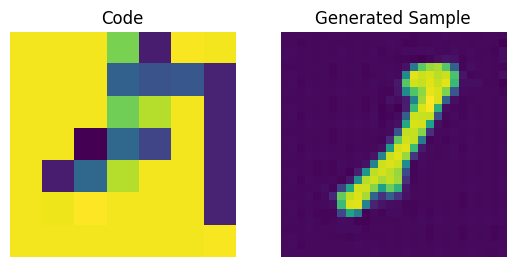

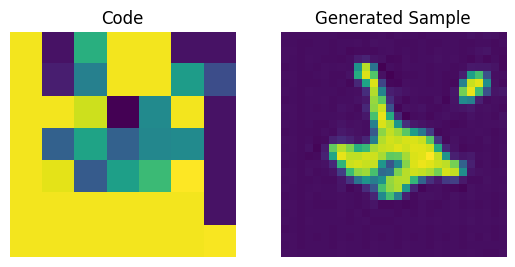

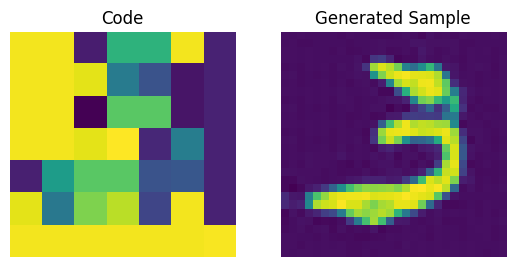

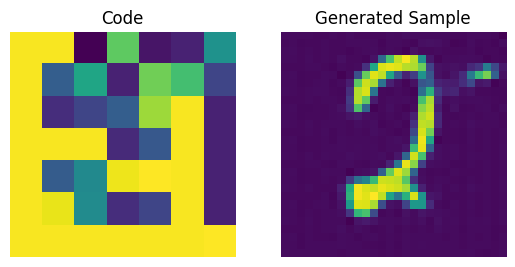

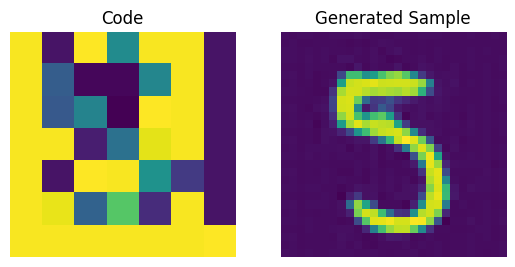

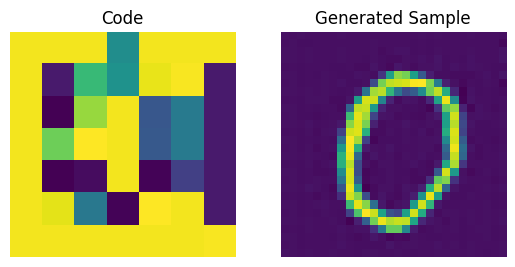

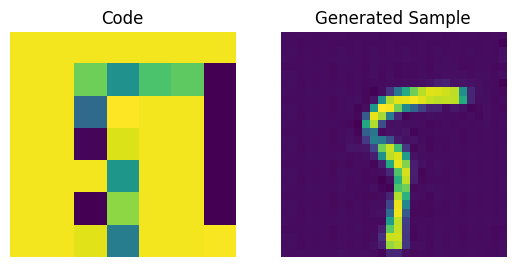

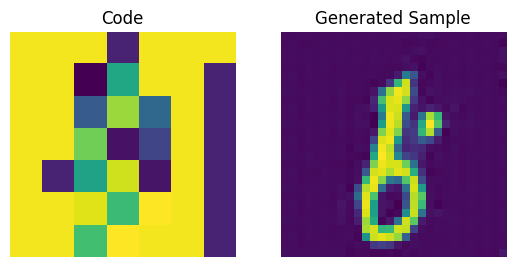

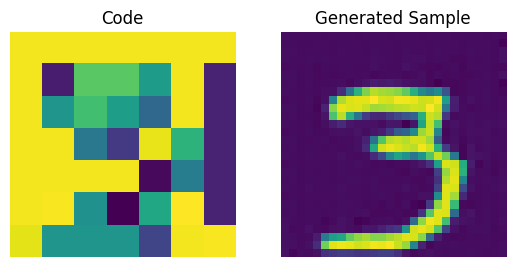

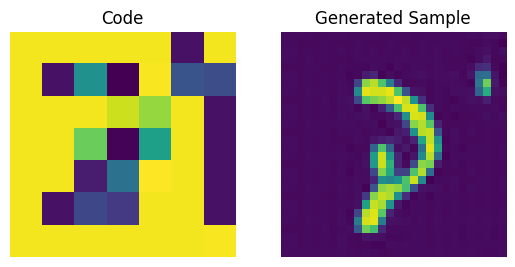

In [22]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

We can enhance the quality of these generated samples by tweaking the PixelCNN.



## Additional notes

* After the VQ-VAE paper was initially released, the authors developed an exponential
moving averaging scheme to update the embeddings inside the quantizer. If you're
interested you can check out
[this snippet](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py#L124).
* To further enhance the quality of the generated samples,
[VQ-VAE-2](https://arxiv.org/abs/1906.00446) was proposed that follows a cascaded
approach to learn the codebook and to generate the images.